In [1]:
using Lux
using SciMLSensitivity
using DiffEqFlux
using DifferentialEquations
using Plots
using Plots.PlotMeasures
using Zygote
using Random
rng = Random.seed!(1234)
using OptimizationOptimisers
using Statistics
using ComponentArrays
using CUDA
using Images
using Interpolations
using NNlib
using FFTW
ArrayType = CUDA.functional() ? CuArray : Array;
# Import our custom backend functions
include("coupling_functions/functions_example.jl")
include("coupling_functions/functions_NODE.jl")
include("coupling_functions/functions_CNODE_loss.jl")
include("coupling_functions/functions_FDderivatives.jl");
include("coupling_functions/functions_nn.jl")
include("coupling_functions/functions_FNO.jl")

create_fno_model (generic function with 1 method)

## Learning the Gray-Scott model (alternative)

In this example, we want to learn a closure to the Gray-Scott model using a Neural Network. We will use the same parameters as in the previous example, but we will use a smaller grid to train the closure. **Compared to `Example2_part2` here we use a coarser grid on both u and v**.

We run multiple GS simulations as discussed in the previous part.
Notice that the 'fine' grid is now only 40 cells per side, in order to speed up the example

In [2]:
dux = duy = dvx = dvy = 1.
nux = nuy = nvx = nvy = 40
grid = Grid(dux, duy, nux, nuy, dvx, dvy, nvx, nvy);

Here, we define the initial condition as a random perturbation over a constant background to add variety

In [3]:
function initial_condition(grid, U₀, V₀, ε_u, ε_v; nsimulations=1)
    u_init = U₀ .+ ε_u .* randn(grid.nux, grid.nuy, nsimulations)
    v_init = V₀ .+ ε_v .* randn(grid.nvx, grid.nvy, nsimulations)
    return u_init, v_init
end
U₀ = 0.5    # initial concentration of u
V₀ = 0.25   # initial concentration of v
ε_u = 0.05 # magnitude of the perturbation on u
ε_v = 0.1 # magnitude of the perturbation on v
u_initial, v_initial = initial_condition(grid, U₀, V₀, ε_u, ε_v, nsimulations=4);

We can now define the initial condition as a flattened concatenated array

In [4]:
uv0 = vcat(reshape(u_initial, grid.nux*grid.nuy,:),reshape(v_initial, grid.nvx*grid.nvy,:));

From the literature, we have selected the following parameters in order to form nice patterns

In [5]:
D_u = 0.16
D_v = 0.08
f = 0.055
k = 0.062;

RHS of GS model

In [6]:
F_u(u,v,grid) = D_u*Laplacian(u,grid.dux,grid.duy) .- u.*v.^2 .+ f.*(1.0.-u)
G_v(u,v,grid) = D_v*Laplacian(v,grid.dvx,grid.dvy) .+ u.*v.^2 .- (f+k).*v

G_v (generic function with 1 method)

and definition of the model

In [7]:
f_CNODE = create_f_CNODE(F_u, G_v, grid; is_closed=false);
θ, st = Lux.setup(rng, f_CNODE);

No need to resize v


Short *burnout run* to get rid of the initial artifacts

In [8]:
trange_burn = (0.0f0, 50.0f0)
dt, saveat = (1e-2, 1)
full_CNODE = NeuralODE(f_CNODE, trange_burn, Tsit5(), adaptive=false, dt=dt, saveat=saveat);
burnout_data = Array(full_CNODE(uv0, θ, st)[1]);

Second burnout with larger timesteps

In [9]:
trange_burn = (0.0f0, 100.0f0)
dt, saveat = (1, 50)
full_CNODE = NeuralODE(f_CNODE, trange_burn, Tsit5(), adaptive=false, dt=dt, saveat=saveat);
burnout_data = Array(full_CNODE(burnout_data[:,:,end], θ, st)[1]);
u = reshape(burnout_data[1:grid.Nu, :, :]    , grid.nux, grid.nuy, size(burnout_data,2), :);
v = reshape(burnout_data[grid.Nu+1:end, :, :], grid.nvx, grid.nvy, size(burnout_data,2), :);

**Data collection run**
We use the output of the burnout to start a longer simulations

In [10]:
uv0 = burnout_data[:,:,end]
trange = (0.0f0, 2500.0f0)

(0.0f0, 2500.0f0)

for this data production run, we set `dt=1` and we sample every step

In [11]:
dt, saveat = (0.1, 0.1)
full_CNODE = NeuralODE(f_CNODE, trange, Tsit5(), adaptive=false, dt=dt, saveat=saveat);
reference_data = Array(full_CNODE(uv0, θ, st)[1]);

And we unpack the solution to get the two species from

In [12]:
u = reshape(reference_data[1:grid.Nu, :, :]    , grid.nux, grid.nuy, size(reference_data,2), :);
v = reshape(reference_data[grid.Nu+1:end, :, :], grid.nvx, grid.nvy, size(reference_data,2), :);

Plot the data

┌ Info: Saved animation to /tmp/jl_p8xWjSn03M.gif
└ @ Plots /home/simone/.julia/packages/Plots/HyyIK/src/animation.jl:156


┌ Info: Saved animation to /home/simone/Dropbox/eScience_projects/DEEPDIEP-repos/SciML-model-coupling/examples/plots/multi_GS.gif
└ @ Plots /home/simone/.julia/packages/Plots/HyyIK/src/animation.jl:156


Plots.AnimatedGif("/home/simone/Dropbox/eScience_projects/DEEPDIEP-repos/SciML-model-coupling/examples/plots/multi_GS.gif")
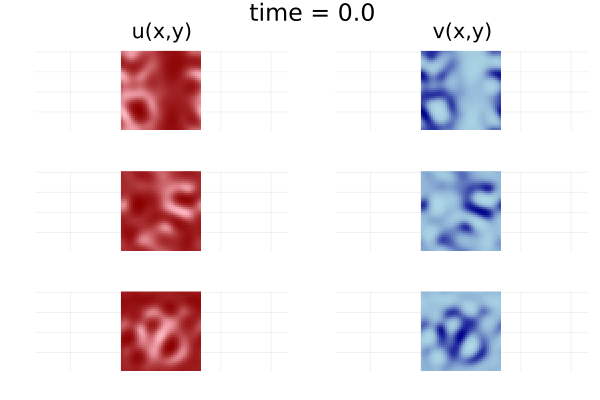

In [13]:
anim = Animation()
fig = plot(layout = (3, 2), size = (600, 900))
@gif for i in 1:1000:size(u, 4)
    p1 = heatmap(u[:,:,1,i], axis=false, cbar=false, aspect_ratio=1, color=:reds , title="u(x,y)")
    p2 = heatmap(v[:,:,1,i], axis=false, cbar=false, aspect_ratio=1, color=:blues, title="v(x,y)")
    p3 = heatmap(u[:,:,2,i], axis=false, cbar=false, aspect_ratio=1, color=:reds  )
    p4 = heatmap(v[:,:,2,i], axis=false, cbar=false, aspect_ratio=1, color=:blues )
    p5 = heatmap(u[:,:,3,i], axis=false, cbar=false, aspect_ratio=1, color=:reds  )
    p6 = heatmap(v[:,:,3,i], axis=false, cbar=false, aspect_ratio=1, color=:blues )
    time = round(i*saveat, digits=0)
    fig = plot(p1, p2, p3, p4, p5, p6, layout=(3,2), plot_title="time = $(time)")
    frame(anim, fig)
end
if isdir("./plots")
    gif(anim, "./plots/multi_GS.gif", fps=10)
else
    gif(anim, "examples/plots/multi_GS.gif", fps=10)
end

### Collect the data for the coarse grid
So now we redefine the grid parameters

In [14]:
nvx = nvy = nux = nuy = 30
dvx = 40*dux/nvx
dvy = 40*duy/nvy
dux = 40*dux/nvx
duy = 40*duy/nvy
coarse_grid = Grid(dux, duy, nux, nuy, dvx, dvy, nvx, nvy);

Here we show what happens if you use a non-closed model on the coarse grid of this example

No need to resize v


┌ Info: Saved animation to /tmp/jl_tElQLqTgPE.gif
└ @ Plots /home/simone/.julia/packages/Plots/HyyIK/src/animation.jl:156


┌ Info: Saved animation to /home/simone/Dropbox/eScience_projects/DEEPDIEP-repos/SciML-model-coupling/examples/plots/multi_GS_coarse_alternative.gif
└ @ Plots /home/simone/.julia/packages/Plots/HyyIK/src/animation.jl:156


Plots.AnimatedGif("/home/simone/Dropbox/eScience_projects/DEEPDIEP-repos/SciML-model-coupling/examples/plots/multi_GS_coarse_alternative.gif")
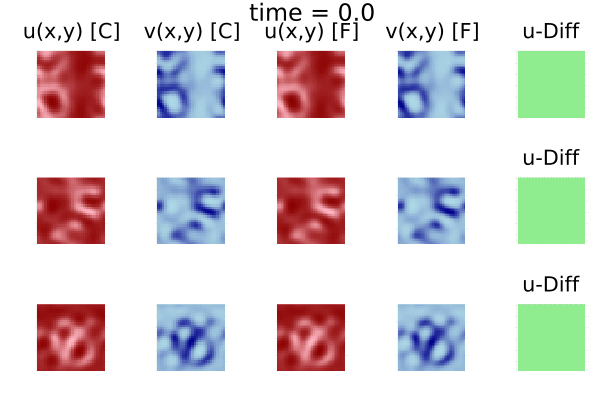

In [15]:
f_coarse_CNODE = create_f_CNODE(F_u, G_v, coarse_grid; is_closed=false)
θ, st = Lux.setup(rng, f_coarse_CNODE);
uv0 = burnout_data[:,:,end];
u0b = reshape(uv0[1:grid.nux*grid.nuy, :]    , grid.nux, grid.nuy,:);
v0b = reshape(uv0[grid.nux*grid.nuy+1:end, :], grid.nvx, grid.nvy,:);
u0_coarse = imresize(u0b, (coarse_grid.nux,coarse_grid.nuy));
v0_coarse = imresize(v0b, (coarse_grid.nvx,coarse_grid.nvy));
uv0_coarse = vcat(reshape(u0_coarse, coarse_grid.nux*coarse_grid.nuy,:),reshape(v0_coarse, coarse_grid.nvx*coarse_grid.nvy,:));
closed_CNODE = NeuralODE(f_coarse_CNODE, trange, Tsit5(), adaptive=false, dt=dt, saveat=saveat);
closed_CNODE_solution = Array(closed_CNODE(uv0_coarse, θ, st)[1]);
u_closed = reshape(closed_CNODE_solution[1:coarse_grid.nux*coarse_grid.nuy, :, :]    , coarse_grid.nux, coarse_grid.nuy, size(closed_CNODE_solution,2), :);
v_closed = reshape(closed_CNODE_solution[coarse_grid.nux*coarse_grid.nuy+1:end, :, :], coarse_grid.nvx, coarse_grid.nvy, size(closed_CNODE_solution,2), :);
anim = Animation()
fig = plot(layout = (3, 5), size = (500, 300))
@gif for i in 1:1000:size(u_closed, 4)
    p1 = heatmap(u_closed[:,:,1,i], axis=false, cbar=false, aspect_ratio=1, color=:reds , title="u(x,y) [C]")
    p2 = heatmap(v_closed[:,:,1,i], axis=false, cbar=false, aspect_ratio=1, color=:blues, title="v(x,y) [C]")
    p3 = heatmap(u[:,:,1,i], axis=false, cbar=false, aspect_ratio=1, color=:reds , title="u(x,y) [F]")
    p4 = heatmap(v[:,:,1,i], axis=false, cbar=false, aspect_ratio=1, color=:blues, title="v(x,y) [F]")
    e = u_closed[:,:,1,i] .- imresize(u[:,:,1,i], coarse_grid.nux, coarse_grid.nuy)
    p5 = heatmap(e, axis=false, cbar=false, aspect_ratio=1, color=:greens , title="u-Diff")
    p6 = heatmap(u_closed[:,:,2,i], axis=false, cbar=false, aspect_ratio=1, color=:reds  )
    p7 = heatmap(v_closed[:,:,2,i], axis=false, cbar=false, aspect_ratio=1, color=:blues )
    p8 = heatmap(u[:,:,2,i], axis=false, cbar=false, aspect_ratio=1, color=:reds  )
    p9 = heatmap(v[:,:,2,i], axis=false, cbar=false, aspect_ratio=1, color=:blues )
    e = u_closed[:,:,2,i] .- imresize(u[:,:,2,i], coarse_grid.nux, coarse_grid.nuy)
    p10 = heatmap(e, axis=false, cbar=false, aspect_ratio=1, color=:greens , title="u-Diff")
    p11 = heatmap(u_closed[:,:,3,i], axis=false, cbar=false, aspect_ratio=1, color=:reds  )
    p12 = heatmap(v_closed[:,:,3,i], axis=false, cbar=false, aspect_ratio=1, color=:blues )
    p13 = heatmap(u[:,:,3,i], axis=false, cbar=false, aspect_ratio=1, color=:reds  )
    p14 = heatmap(v[:,:,3,i], axis=false, cbar=false, aspect_ratio=1, color=:blues )
    e = u_closed[:,:,3,i] .- imresize(u[:,:,3,i], coarse_grid.nux, coarse_grid.nuy)
    p15 = heatmap(e, axis=false, cbar=false, aspect_ratio=1, color=:greens , title="u-Diff")
    time = round(i*saveat, digits=0)
    fig = plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, layout=(3,5), plot_title="time = $(time)")
    frame(anim, fig)
end
if isdir("./plots")
    gif(anim, "./plots/multi_GS_coarse_alternative.gif", fps=10)
else
    gif(anim, "examples/plots/multi_GS_coarse_alternative.gif", fps=10)
end

In order to prepare the loss function, we compute from the simulation data the target that we would like to fit. In the example u will be unchanged, while v will be rescaled to the coarse grid

In [16]:
u = reshape(reference_data[1:grid.nux*grid.nuy, :, :]    , grid.nux, grid.nuy, size(reference_data,2), :);
v = reshape(reference_data[grid.nux*grid.nuy+1:end, :, :], grid.nvx, grid.nvy, size(reference_data,2), :);
u_target = imresize(u, (coarse_grid.nvx,coarse_grid.nvy));
v_target = imresize(v, (coarse_grid.nvx,coarse_grid.nvy));

and pack them together in a target array where u and v are linearized in the first dimension

In [17]:
target = vcat(reshape(u_target, coarse_grid.nux*coarse_grid.nuy, size(u_target,3), :),reshape(v_target, coarse_grid.nvx*coarse_grid.nvy, size(v_target,3), :));

and make it into float32

In [18]:
target = target |> f32;

Now create the CNODE with the Neural Network

In [19]:
ch_fno = [2, 5, 5, 5, 2];
kmax_fno = [8, 8, 8, 8];
σ_fno = [gelu, gelu, gelu,  identity];
NN_u = create_fno_model(kmax_fno, ch_fno, σ_fno);
NN_v = create_fno_model(kmax_fno, ch_fno, σ_fno);

We can now close the CNODE with the Neural Network

In [20]:
f_closed_CNODE = create_f_CNODE(F_u, G_v, coarse_grid, NN_u, NN_v; is_closed=true) ;

No need to resize v


and make it into float32

In [21]:
f_closed_CNODE = f_closed_CNODE |> f32;
θ, st = Lux.setup(rng, f_closed_CNODE);

### Design the **loss function**
For this example, we use *multishooting a posteriori* fitting (MulDtO), where we tell `Zygote` to compare `nintervals` of length `nunroll` to get the gradient. Notice that this method is differentiating through the solution of the NODE!

In [22]:
nunroll = 5
nintervals = 5
nsamples = 2

2

We also define this auxiliary NODE that will be used for training
We can use smaller time steps for the training because the untrained parameters will cause unstability

In [23]:
dt_train = 0.05

0.05

but we have to sample at the same rate as the data

In [24]:
saveat_train = saveat
t_train_range = (0.0f0, saveat_train*(nunroll+0)) # it has to be as long as unroll
training_CNODE = NeuralODE(f_closed_CNODE, t_train_range, Tsit5(), adaptive=false, dt=dt_train, saveat=saveat_train);

* Create the loss

In [25]:
myloss = create_randloss_MulDtO(target, nunroll=nunroll, nintervals=nintervals, nsamples=nsamples, λ=0.1);

To initialize the training, we need some objects to monitor the procedure, and we trigger the first compilation.

In [26]:
lhist = Float32[];

Initialize and trigger the compilation of the model

In [27]:
pinit = ComponentArray(θ);
myloss(pinit)  # trigger compilation

(216.20129799959832, nothing)

[!] Check that the loss does not get type warnings, otherwise it will be slower

Select the autodifferentiation type

In [28]:
adtype = Optimization.AutoZygote();

We transform the NeuralODE into an optimization problem

In [29]:
optf = Optimization.OptimizationFunction((x, p) -> myloss(x), adtype);
optprob = Optimization.OptimizationProblem(optf, pinit);

Select the training algorithm:
we choose Adam with learning rate 0.01, with gradient clipping

In [30]:
ClipAdam = OptimiserChain(Adam(1.0f-2), ClipGrad(1));

Finally we can train the NODE

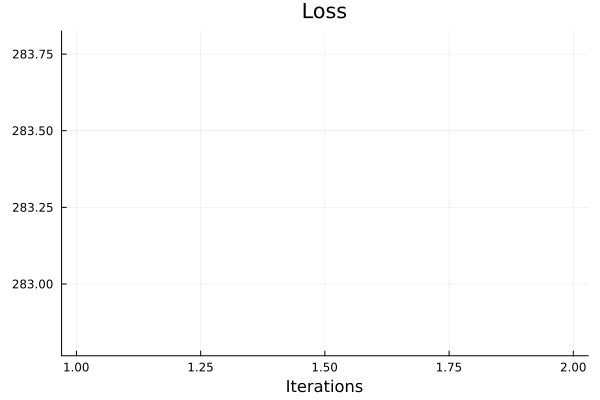

Loss[0]: 282.79577939546147


Loss[1]: 287.2905822701752


Loss[2]: 327.1421631753445


Loss[3]: 282.79577939546147


In [31]:
result_neuralode = Optimization.solve(optprob,
    ClipAdam;
    callback = callback,
    maxiters = 3
    );
pinit = result_neuralode.u;
optprob = Optimization.OptimizationProblem(optf, pinit);

(Notice that the block above can be repeated to continue training)

**Notice** that the training is rather slow, so realistically here you can not expect good results in a few iterations.

and finally I use the trained CNODE to compare the solution with the target

┌ Info: Saved animation to /tmp/jl_3Utu9O7gdk.gif
└ @ Plots /home/simone/.julia/packages/Plots/HyyIK/src/animation.jl:156


┌ Info: Saved animation to /home/simone/Dropbox/eScience_projects/DEEPDIEP-repos/SciML-model-coupling/examples/plots/trained_GS_alternative.gif
└ @ Plots /home/simone/.julia/packages/Plots/HyyIK/src/animation.jl:156


Plots.AnimatedGif("/home/simone/Dropbox/eScience_projects/DEEPDIEP-repos/SciML-model-coupling/examples/plots/trained_GS_alternative.gif")
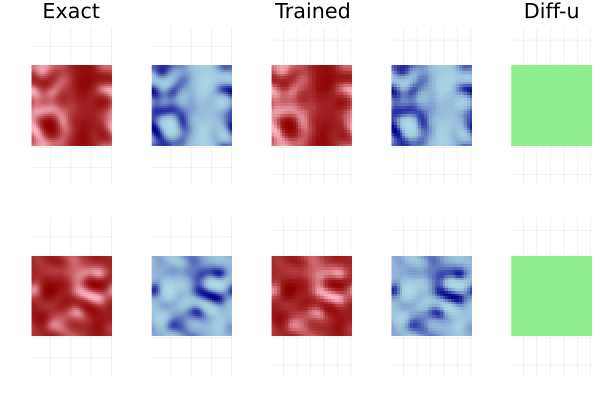

In [34]:
trange = (0.0f0, 300.0f0)
trained_CNODE = NeuralODE(f_closed_CNODE, trange, Tsit5(), adaptive=false, dt=dt, saveat=saveat);
trained_CNODE_solution = Array(trained_CNODE(uv0_coarse[:,1:3], θ, st)[1]);
u_trained = reshape(trained_CNODE_solution[1:coarse_grid.Nu, :, :]    , coarse_grid.nux, coarse_grid.nuy, size(trained_CNODE_solution,2), :);
v_trained = reshape(trained_CNODE_solution[coarse_grid.Nu+1:end, :, :], coarse_grid.nvx, coarse_grid.nvy, size(trained_CNODE_solution,2), :);
anim = Animation()
fig = plot(layout = (2, 5), size = (750, 300))
@gif for i in 1:40:size(u_trained, 4)
    p1 = heatmap(u[:,:,1,i], axis=false, cbar=false, aspect_ratio=1, color=:reds, title="Exact" )
    p2 = heatmap(v[:,:,1,i], axis=false, cbar=false, aspect_ratio=1, color=:blues)
    p3 = heatmap(u_trained[:,:,1,i], axis=false, cbar=false, aspect_ratio=1, color=:reds, title="Trained")
    p4 = heatmap(v_trained[:,:,1,i], axis=false, cbar=false, aspect_ratio=1, color=:blues)
    et = abs.(imresize(u[:,:,1,i],coarse_grid.nux,coarse_grid.nuy) .- u_trained[:,:,1,i])
    p5 = heatmap(et, axis=false, cbar=false, aspect_ratio=1, color=:greens, title = "Diff-u")
    p6 = heatmap(u[:,:,2,i], axis=false, cbar=false, aspect_ratio=1, color=:reds  )
    p7 = heatmap(v[:,:,2,i], axis=false, cbar=false, aspect_ratio=1, color=:blues )
    p8 = heatmap(u_trained[:,:,2,i], axis=false, cbar=false, aspect_ratio=1, color=:reds )
    p9 = heatmap(v_trained[:,:,2,i], axis=false, cbar=false, aspect_ratio=1, color=:blues )
    e = abs.(imresize(u[:,:,2,i],coarse_grid.nux,coarse_grid.nuy) .- u_trained[:,:,2,i])
    p10 = heatmap(e, axis=false, cbar=false, aspect_ratio=1, color=:greens )

    time = round(i*saveat, digits=0)
    fig = plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, layout=(2,5), margin =0mm)

    frame(anim, fig)
end
if isdir("./plots")
    gif(anim, "./plots/trained_GS_alternative.gif", fps=10)
else
    gif(anim, "examples/plots/trained_GS_alternative.gif", fps=10)
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*